In [126]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.tree import DecisionTreeClassifier, plot_tree
from backtesting import Backtest, Strategy
from datetime import datetime

Initial data fetching

In [127]:
df = yf.download("AAPL")
df = df.loc['2016-12-08':,:]
df['change_tomorrow'] = df.Close.pct_change(-1) * 100 * -1
df = df.dropna().copy()
df['change_tomorrow_direction'] = np.where(df.change_tomorrow > 0, 'Up', 'Down')

[*********************100%***********************]  1 of 1 completed
/var/folders/33/_ft973790qv2wpzyrpc3p2fr0000gn/T/ipykernel_26610/1875607601.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['change_tomorrow'] = df.Close.pct_change(-1) * 100 * -1


In [128]:
target = df.change_tomorrow_direction
explanatory = df.drop(columns=['change_tomorrow', 'change_tomorrow_direction'])

[Text(0.12904772384305835, 0.96875, 'Volume <= 37274950.0\ngini = 0.497\nsamples = 1961\nvalue = [909, 1052]'),
 Text(0.0482897384305835, 0.90625, 'Open <= 226.64\ngini = 0.36\nsamples = 17\nvalue = [13, 4]'),
 Text(0.08866873113682092, 0.9375, 'True  '),
 Text(0.04024144869215292, 0.84375, 'Adj Close <= 220.184\ngini = 0.305\nsamples = 16\nvalue = [13, 3]'),
 Text(0.03219315895372234, 0.78125, 'Close <= 206.925\ngini = 0.397\nsamples = 11\nvalue = [8, 3]'),
 Text(0.02414486921529175, 0.71875, 'Open <= 193.695\ngini = 0.32\nsamples = 10\nvalue = [8, 2]'),
 Text(0.01609657947686117, 0.65625, 'Close <= 189.975\ngini = 0.444\nsamples = 6\nvalue = [4, 2]'),
 Text(0.008048289738430584, 0.59375, 'gini = 0.0\nsamples = 3\nvalue = [3, 0]'),
 Text(0.02414486921529175, 0.59375, 'Adj Close <= 190.22\ngini = 0.444\nsamples = 3\nvalue = [1, 2]'),
 Text(0.01609657947686117, 0.53125, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.03219315895372234, 0.53125, 'Low <= 191.55\ngini = 0.5\nsamples = 

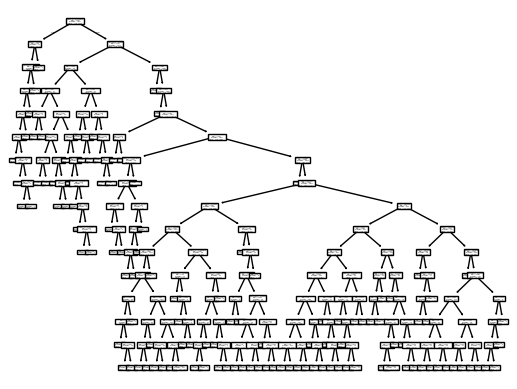

In [129]:
model_dt = DecisionTreeClassifier(max_depth=15)
model_dt.fit(X=explanatory,y=target)

plot_tree(decision_tree=model_dt, feature_names=model_dt.feature_names_in_)

In [130]:
y_pred = model_dt.predict(X=explanatory)
df_predictions = df[['change_tomorrow_direction']].copy()
df_predictions['predictions'] = y_pred
df_predictions

,change_tomorrow_direction,predictions
Date,,
2016-12-08,Up,Up
2016-12-09,Down,Down
2016-12-12,Up,Up
2016-12-13,Down,Down
2016-12-14,Up,Up
...,...,...
2024-09-19,Down,Down
2024-09-20,Down,Down
2024-09-23,Up,Up


In [131]:
comp = df_predictions.change_tomorrow_direction == df_predictions.predictions
model_accuracy = model_dt.score(X=explanatory, y=target)
model_accuracy

0.6598674145843957

In [132]:
explanatory_today = explanatory.iloc[[-1],:]
prediction = model_dt.predict(explanatory_today)[0]

In [137]:
class ClassificationUp(Strategy):  
    def init(self):
        self.model = model_dt 

    def next(self):
        explanatory_today = self.data.df.iloc[[-1], :].drop(columns=['change_tomorrow', 'change_tomorrow_direction']) 
        
        forecast_tomorrow = self.model.predict(explanatory_today)[0] 
        
        if forecast_tomorrow == 'Up':  
            self.position.close()
            self.buy()
        elif forecast_tomorrow == 'Down':  
            self.position.close()
            self.sell()

In [140]:
bt = Backtest(df, ClassificationUp, cash=10000, commission=0.002) 
stats = bt.run()
stats

Down
Up
Down
Up
Up
Up
Up
Up
Down
Up
Up
Down
Down
Down
Up
Down
Up
Up
Up
Up
Up
Down
Down
Up
Down
Down
Up
Up
Down
Up
Up
Up
Down
Down
Up
Down
Up
Up
Up
Up
Up
Down
Up
Up
Up
Down
Up
Up
Up
Down
Up
Up
Up
Up
Down
Up
Down
Up
Down
Down
Up
Up
Down
Up
Up
Down
Up
Down
Up
Down
Down
Up
Up
Up
Down
Down
Up
Up
Down
Down
Down
Down
Up
Up
Down
Up
Down
Down
Up
Up
Up
Up
Down
Up
Down
Up
Up
Up
Up
Up
Up
Up
Down
Up
Down
Down
Down
Down
Down
Up
Up
Down
Down
Up
Down
Down
Down
Up
Up
Down
Down
Down
Down
Down
Down
Up
Up
Up
Down
Up
Down
Up
Up
Up
Up
Up
Up
Down
Up
Down
Up
Down
Up
Down
Down
Up
Up
Up
Up
Up
Up
Up
Down
Up
Up
Up
Down
Down
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Down
Down
Up
Up
Down
Up
Down
Down
Down
Down
Down
Down
Down
Up
Down
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up
Up

Start                     2016-12-08 00:00:00
End                       2024-09-25 00:00:00
Duration                   2848 days 00:00:00
Exposure Time [%]                   99.898011
Equity Final [$]                 38880.123631
Equity Peak [$]                  39888.179715
Return [%]                         288.801236
Buy & Hold Return [%]              707.598964
Return (Ann.) [%]                    19.06482
Volatility (Ann.) [%]               34.957477
Sharpe Ratio                         0.545372
Sortino Ratio                        0.939731
Calmar Ratio                         0.281613
Max. Drawdown [%]                  -67.698602
Avg. Drawdown [%]                   -4.522316
Max. Drawdown Duration     1532 days 00:00:00
Avg. Drawdown Duration       52 days 00:00:00
# Trades                                 1959
Win Rate [%]                        52.986217
Best Trade [%]                       9.506552
Worst Trade [%]                     -9.334877
Avg. Trade [%]                    